In [2]:
from syuron import shg
import matplotlib as mpl

current_font_size = mpl.rcParams['font.size']
mpl.rcParams['font.size'] = current_font_size * 1.5
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

shg.use_gpu()

GPUを使用します: [CudaDevice(id=0)]


True

In [2]:
def create_paired_pplt_widths(L, Lambda0, chirp_factor=0.0):
    widths = []
    z_current = 0.0
    pair_index = 0  # ペアのインデックス
    while z_current < L:
        # ペアごとにチャープを計算
        current_lambda = Lambda0 / (1 + chirp_factor * pair_index)
        half_period = current_lambda / 2.0
        # 次のペア全体がLを超えないか確認
        if z_current + current_lambda <= L:
            # 1ペア（2つのドメイン）を追加
            widths.append(half_period)
            widths.append(half_period)
            z_current += current_lambda
            # 次のペアへ
            pair_index += 1
        else:
            # Lを超える場合はループを終了
            break
    return widths


def create_pplt_widths(L, Lambda0, chirp_factor=0.0):
    widths = []
    z_current = 0.0
    while z_current < L:
        # 現在位置での周期長を計算（チャープ関数）
        # chirp_factor = 0 の場合は均一な構造になる
        current_lambda = Lambda0 / (1 + chirp_factor * z_current)
        half_period = current_lambda / 2.0
        widths.append(half_period)
        z_current += current_lambda
    return widths

In [5]:
from matplotlib import pyplot as plt
import numpy as np


def show_widths_info(widths):
    """
    周期分極構造のwidths配列の情報を表示する関数

    Args:
        widths: 分極ドメインの幅リスト
    """
    # NumPy配列に変換（もしJAX配列の場合）
    if hasattr(widths, 'tolist'):
        widths_np = np.array(widths)
    else:
        widths_np = np.array(widths)

    # 基本統計情報
    min_width = np.min(widths_np)
    max_width = np.max(widths_np)
    avg_width = np.mean(widths_np)
    total_length = np.sum(widths_np)
    num_domains = len(widths_np)

    # 結果の表示
    print(f"周期分極構造の情報:")
    print(f"総ドメイン数: {num_domains}")
    print(f"総長: {total_length:.4f} µm")
    print(f"平均幅: {avg_width:.4f} µm")
    print(f"最小幅: {min_width:.4f} µm")
    print(f"最大幅: {max_width:.4f} µm")

    # グラフ表示
    plt.figure(figsize=(12, 8))

    # サブプロット1: ドメイン幅のプロット
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(widths_np)), widths_np * 1e6, 'b-')
    plt.xlabel('ドメインインデックス')
    plt.ylabel('ドメイン幅 (μm)')
    plt.title(f'周期分極構造のドメイン幅')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 幅の分布もヒストグラムで表示
    plt.figure(figsize=(10, 6))
    plt.hist(widths_np * 1e6, bins=30, alpha=0.7, color='green')
    plt.xlabel('ドメイン幅 (μm)')
    plt.ylabel('頻度')
    plt.title('ドメイン幅の分布')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
from typing import NamedTuple, List


class Input(NamedTuple):
    shg_efficiency: List[float]


class Output(NamedTuple):
    domain_width: List[float]

[3.6, 3.6, 3.6]
周期分極構造の情報:
総ドメイン数: 1000
総長: 3600.0000 µm
平均幅: 3.6000 µm
最小幅: 3.6000 µm
最大幅: 3.6000 µm


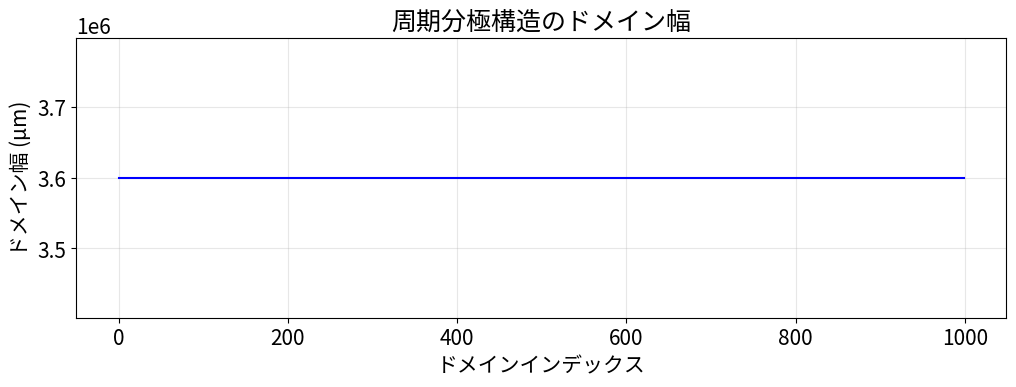

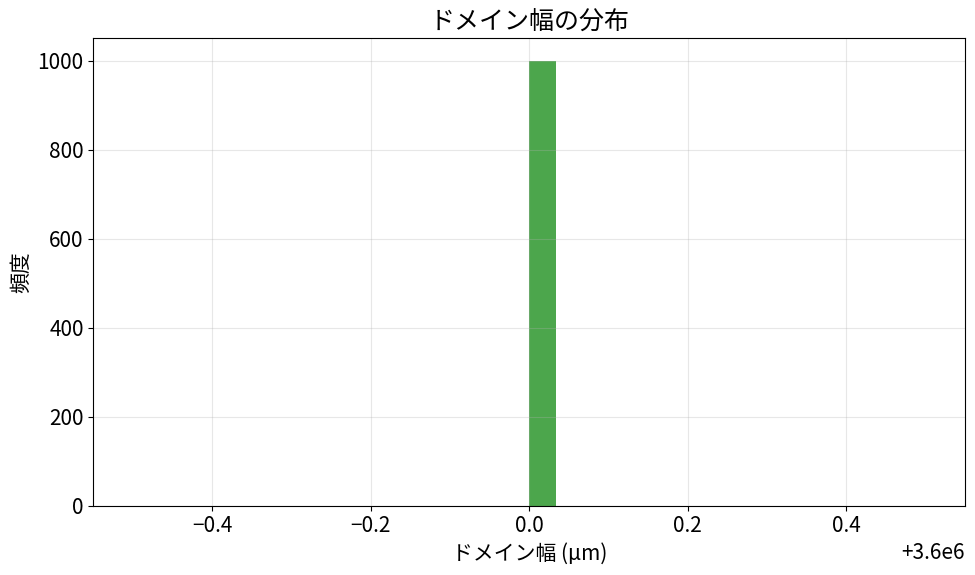

In [6]:
L = 2000
chirp_factor = 0.0001
grating_period = 7.2
# widths = create_pplt_widths(L, grating_period, chirp_factor)
widths_short = [grating_period/2] * 1000
print(widths_short[10:13])
show_widths_info(widths_short)

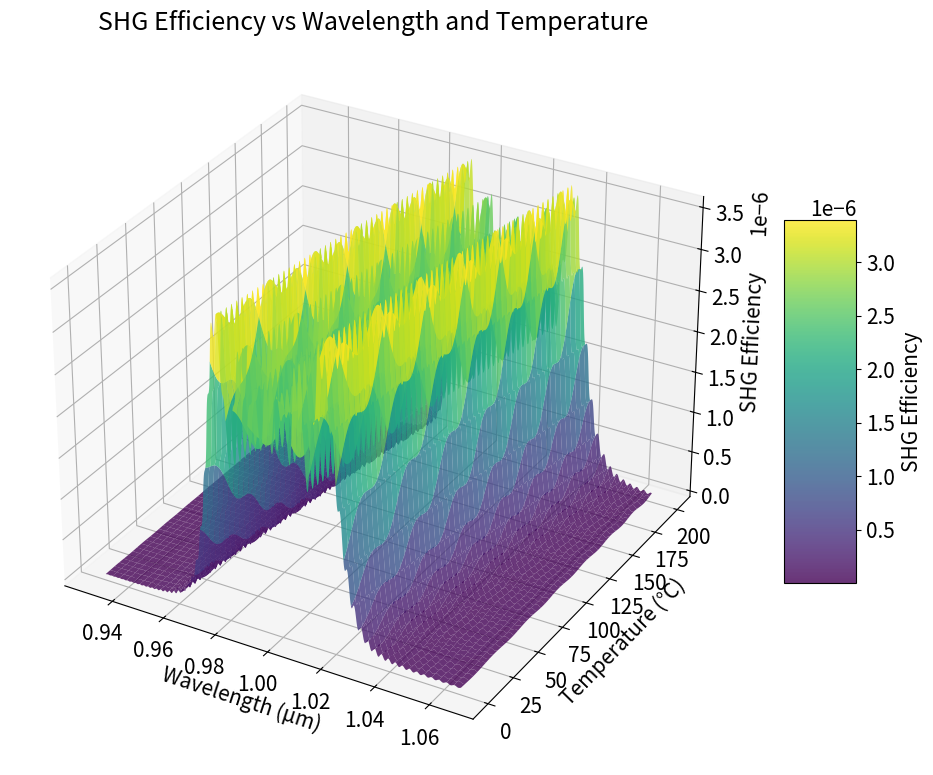

In [7]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.numpy as jnp

# デバイスを設定
L = 2000
kappa_magnitude = 1.31e-05
grating_period = 7.2
widths_short = jnp.array(create_pplt_widths(L, grating_period, 0.0001))
device = shg.PPMgOSLT(widths_short, kappa_magnitude)

# ソルバを設定
wavelength_range = jnp.linspace(0.931, 1.066, 1000)
T_range = jnp.linspace(0, 200, 200)
wavelength, T = jnp.meshgrid(wavelength_range, T_range)
solver = shg.EulerNCMESolver(device, wavelength, T)

# 初期値を設定して計算
A0 = 1.0
B0 = 0.0
eff = solver.solve(A0, B0)

# 3Dプロットの作成
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(wavelength, T, eff, cmap='viridis',  # type: ignore
                       edgecolor='none', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='SHG Efficiency')
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('SHG Efficiency')  # type: ignore
ax.set_title('SHG Efficiency vs Wavelength and Temperature')

plt.tight_layout()
plt.show()

周期分極構造の情報:
総ドメイン数: 306
総長: 1001.6071 µm
平均幅: 3.2732 µm
最小幅: 3.0007 µm
最大幅: 3.6000 µm


/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missi

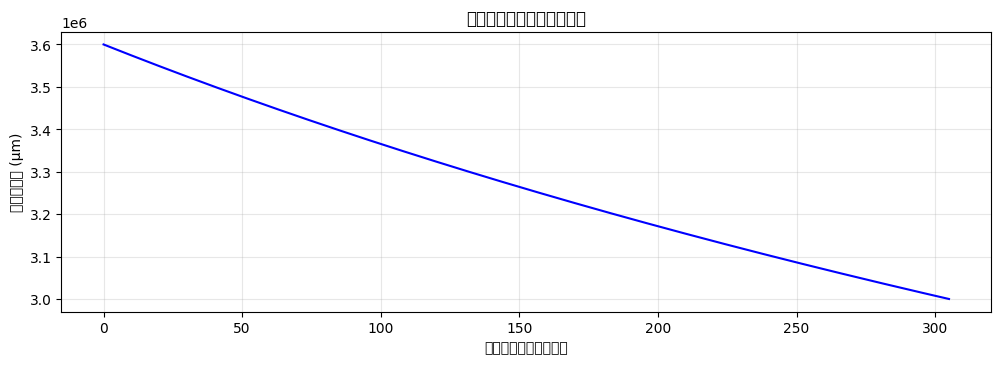

/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1245922/2092023999.py:52: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing fro

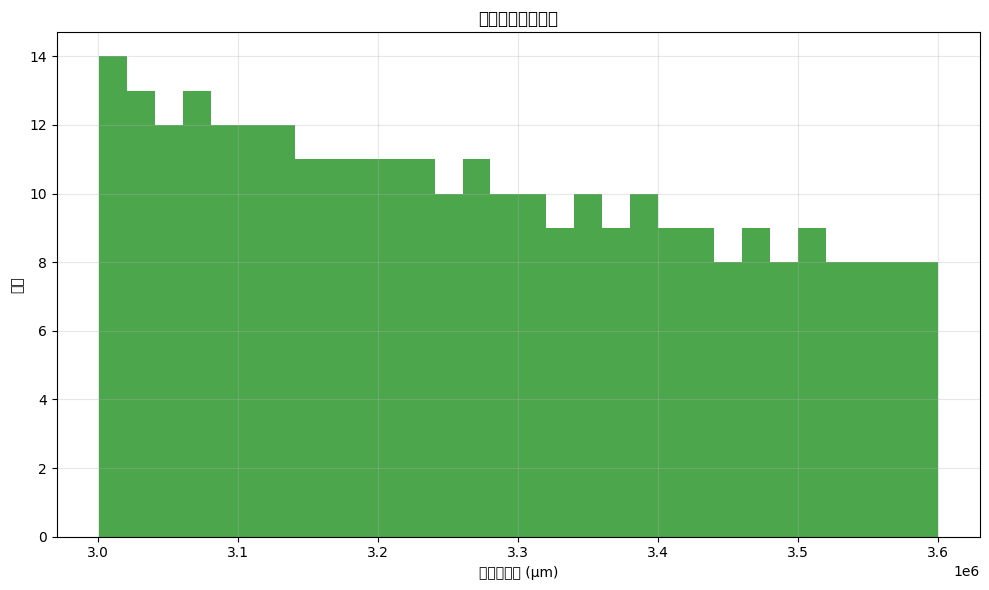

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from syuron import shg

# デバイスを設定
L = 2000
chirp_factor = 0.0001
grating_period = 7.2
kappa_magnitude = 1.31e-05
grating_period_short = 6.8
grating_period_long = 7.2
# 幅は一定値なのでlinspaceで同じ値を1000個作成
widths = create_pplt_widths(L, grating_period, chirp_factor)
widths = jnp.array(widths)
show_widths_info(widths)
# widths_short = jnp.linspace(grating_period_short/2, grating_period_short/2, 500)
# widths_long = jnp.linspace(grating_period_long/2, grating_period_long/2, 500)
# widths = jnp.concatenate([widths_long, widths_short])
# widths = jnp.concatenate([widths_short, widths_long])

# チャープドドメイン幅生成
device = shg.PPMgOSLT(widths, kappa_magnitude)


""" def create_widths(L, Lambda0, chirp=0.0):
    widths, z = [], 0.0
    while z < L:
        current = Lambda0 / (1 + chirp * z)
        widths.append(current / 2)
        z += current
    return widths


# 均一なドメイン幅
chirp = create_widths(2000, 7.2, 0.0001)
pp1 = [3.6] * round(sum(chirp)/3.6)
pp2 = [3.4] * round(sum(chirp)/3.4)

device = shg.PPMgOSLT(jnp.array(pp2), kappa_magnitude)
 """

# 固定温度70度で計算するため、wavelength_rangeのみを変化させる
wavelength_range = jnp.linspace(0.931, 1.066, 1000)
T_fixed = 70.0  # 温度は70度に固定
# 固定温度を1要素の配列としてsolverに渡す
solver = shg.EulerNCMESolver(device, wavelength_range, jnp.array([T_fixed]))

# 初期値を設定して計算
A0 = 1.0
B0 = 0.0
eff = solver.solve(A0, B0)
# effの形状は (1, 1000) となるので、唯一の行を取り出す
# eff_line = eff[0, :]

# 2Dプロットの作成
plt.figure(figsize=(10, 8))
plt.plot(wavelength_range, eff, label='SHG Efficiency')
plt.xlabel('Wavelength (μm)')
plt.ylabel('SHG Efficiency')
plt.title('SHG Efficiency vs Wavelength at 70°C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()